<img src='prelim_iNUX_logo.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='25%'></img>

# Flow between two Ditches
Analytical solution for 1D, unconfined Darcy flow with two Dirichlet boundary conditions and defined recharge.

$h(x)=\sqrt{H_l^2-\frac{H_l^2-H_r^2}{L}x+\frac{q_n}{K}x(L-x)}$

* $x$ = Space coordinate, $m$
* $h(x)$ = Hydraulic head at $x$, $m$
* $K$ = Hydraulic conductivity, $\frac{m}{s}$
* $L$ = Distance between the two boundary conditions, $m$
* $H_l$ = Defined hydraulic head at the left side (x=0), $m$
* $H_r$ = Defined hydraulic head at the right side (x=L), $m$
* $q_n$ = Recharge, $\frac{m}{s}$

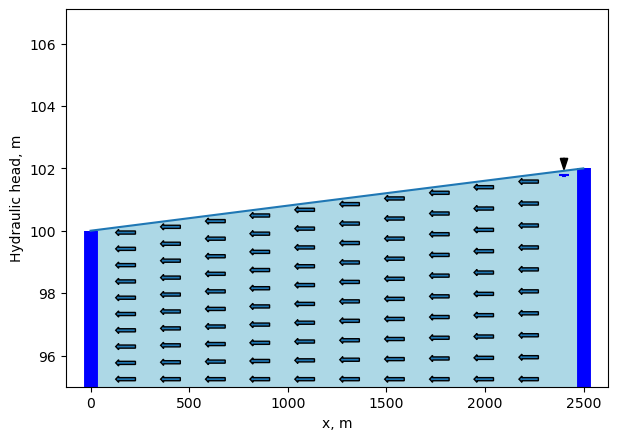

In [1]:
# Initialize libraries
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import *
from IPython.display import display as dspl

# Increase pixel resolution
plt.rcParams["figure.dpi"] = 100

def calculate_head(R, hr, hl, K, L, x):
    """
    Calculate hydraulic head along x for 1D Darcy flow between two Dirichlet B.C. 
    with given recharge
    
    Keyword Arguments:
    R -- recharge in m/s; float
    hr -- hydraulic head at x=0 in m; float
    hl -- hydraulic head at x=L in m; float
    K -- hydraulic conductivity in m/s; float
    L -- distance to hl in m; float
    x -- positions along x in m; float or np.ndarray
    
    Return:
    h -- hydraulic head at positions x; float or np.ndarray
    """
    h=(hl**2-(hl**2-hr**2)/L*x+(R/K*x*(L-x)))**0.5
    return h

def head(hl, hr, L, R, K,y_scale):
    """
    Plot hydraulic head along x
    
    Keyword Arguments:
    hr -- hydraulic head at x=0 in m; float
    hl -- hydraulic head at x=L in m; float
    L -- distance to hl in m; float
    R -- recharge in mm/a; float
    K -- hydraulic conductivity in m/s; float
    y_scale -- scale of y in -; float
    
    Return:
    -
    """
    # Set label sizes
    label_size = 10
    tick_size = 10 
    
    # Transform recharge units from mm/a to m/s
    R=R/1000/365.25/86400
    
    # Calculate head
    x = np.arange(0, L,L/1000)
    h = calculate_head(R, hr, hl, K, L, x)
    
    # Prepare figure and subplots
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(1, 1, 1)
    
    # Plot head
    ax.plot(x,h)
    ax.fill_between(x,0,h, facecolor="lightblue")
    
    # Plot CH-boundaries
    ax.vlines(0, 0, hl, linewidth = 10, color="b")
    ax.vlines(L, 0, hr, linewidth = 10, color="b")
    
    # Make Water-Triangle
    y_range = abs((hl*(1-y_scale/100))-(hr*(1+y_scale/100)))
    h_arrow = (hl**2-(hl**2-hr**2)/L*(L*0.96)+(R/K*(L*0.96)*(L-(L*0.96))))**0.5  #water level at arrow
    ax.arrow(L*0.96,(h_arrow+(h_arrow*0.004)), 0, -0.01, fc="k", ec="k", head_width=(L*0.015), head_length=(y_range*0.03))
    ax.hlines(y= h_arrow-(y_range*0.01), xmin=L*0.95, xmax=L*0.97, colors="blue") 
    ax.hlines(y= h_arrow-(y_range*0.015), xmin=L*0.955, xmax=L*0.965, colors="blue")

    # Add groundwater divide
    max_y = max(h)
    max_x = x[h.argmax()]
    R_min_ms=K*abs(hl**2-hr**2)/L**2
    if R>R_min_ms:
        plt.vlines(max_x,0,max_y, color="r")
    
    # Set y min und max
    y_min = hl*(1-y_scale/100)
    y_max = hr*(1+y_scale/100)
    plt.ylim(y_min, y_max)
    
    # Add flow arrows
    grad_h = np.diff(h)
    num_arows = 10
    max_arrow_length = 100
    start_arrow = 0 + 30 + max_arrow_length
    end_arrow = L - max_arrow_length
    steps = (end_arrow - start_arrow) / num_arows
    numeric_x = np.concatenate((np.arange(max_x,start_arrow, -steps), np.arange(max_x, end_arrow, steps)))
    numeric_x = np.delete(numeric_x, np.argwhere(numeric_x == max_x))
    sample_x = [np.absolute(x-x_val).argmin() for x_val in numeric_x]
    max_grad = np.max(abs(grad_h[sample_x]))
    puffer = (y_max - y_min) * 0.02
    for idx in sample_x:
        arrow_length = max_arrow_length * grad_h[idx] / max_grad
        x_pos = x[idx]
        y_positions = np.linspace(y_min + puffer, h[idx]  - puffer, num_arows)
        for y_pos in y_positions:
            plt.arrow(x_pos, y_pos, -arrow_length, 0, width=0.1, head_width=0.2,head_length=y_scale*3.,length_includes_head=True)
    
    # Add Descriptors
    ax.set_xlabel("x, m",fontsize=label_size)
    ax.set_ylabel("Hydraulic head, m",fontsize=label_size)
    
    # Adjust sizes
    ax.tick_params(axis="both", which="major", labelsize=tick_size)

# Scaling widget
y_scale_WT = widgets.BoundedFloatText(value=5, min=1, max=100, 
                                      step=1, description="y-Scale:",
                                      disabled=False, continuous_update=False)
# Left hydraulic head widget
hl_WT = widgets.BoundedFloatText(value=100, min=0, max=1000, 
                                 step=1, description=r"$H_l, m$:", disabled=False,
                                 continuous_update=False)
# Right hydraulic head widget
hr_WT = widgets.BoundedFloatText(value=102, min=0, max=1000,
                                 step=1, description=r"$H_r, m$:", disabled=False,
                                 continuous_update=False)
# Domain length widget
L_WT = widgets.BoundedFloatText(value=2500,min=0, max=20000,
                                step=100, description=r"$L, m$:" , disabled=False,
                                continuous_update=False)
# Recharge widget
R_WT = widgets.FloatSlider(value=0,min=-500, max=500,
                           step=10,description=r"$R, \frac{mm}{a}$:", disabled=False,
                           continuous_update=False)

# Hydraulic conductivity widget
K_WT = widgets.FloatLogSlider(value=0.0001,base=10,min=-6, max=-2,
                              step=0.1,description=r"$K, \frac{m}{s}$:",readout=True,
                              readout_format=".2e",continuous_update=False)

# Start interactive plot
out = widgets.interactive_output(head,
                                 {"y_scale":y_scale_WT,
                                 "hl":hl_WT,
                                 "hr":hr_WT,
                                 "L":L_WT,
                                 "R":R_WT,
                                 "K":K_WT})
# Sort widgets into desired order
controls = VBox([K_WT, R_WT, hl_WT, hr_WT, L_WT,y_scale_WT])
# Display widgets and output element
widgets.VBox([controls, out])

<hr>

2023 | [Thomas Reimann](mailto:thomas.reimann@tu-dresden.de), [Leonard Grabow](mailto:leonard.grabow@mailbox.tu-dresden.de)
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img style="float: right" alt="Creative Commons Lizenzvertrag" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a>